In [1]:
import os
import numpy as np
import pandas as pd

from dask_searchcv import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import MultiTaskElasticNet

from sklearn.metrics import f1_score, make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Set constants
alphas= [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]
#l1_mixing = [0.1, 0.15, 0.18, 0.2, 0.5, 1]

In [5]:
file = os.path.join('data', 'compass_x_train.tsv.gz')
x_df = pd.read_table(file, index_col=0).T
print(x_df.shape)
x_df.head(2)

(706, 8000)


GENE_ID,ENSG00000000419,ENSG00000001036,ENSG00000001167,ENSG00000001461,ENSG00000001561,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002330,ENSG00000002549,...,ENSG00000273015,ENSG00000273018,ENSG00000273047,ENSG00000273061,ENSG00000273148,ENSG00000273173,ENSG00000273271,ENSG00000273338,ENSG00000273344,ENSG00000273472
MMRF_1021_1_BM,0.002039,0.001428,0.000656,0.001638,0.001126,0.000682,0.002040,0.000836,0.001092,0.003595,...,0.000773,0.000953,0.001499,0.000390,0.000284,0.007063,0.000252,0.005463,0.000286,0.000517
MMRF_1024_2_BM,0.001164,0.000949,0.000828,0.000658,0.000866,0.000776,0.001559,0.000898,0.001600,0.001572,...,0.001248,0.006047,0.000600,0.000672,0.000420,0.004150,0.000222,0.001641,0.000427,0.000931


In [6]:
file = os.path.join('data', 'compass_y_train.tsv')
y_df = pd.read_table(file, index_col=0)
print(y_df.shape)
y_df.head(2)

(706, 1)


,ras_status
MMRF_1021_1_BM,1
MMRF_1024_2_BM,0


In [7]:
weighted_f1 = make_scorer(f1_score, average='weighted')

In [16]:
clf_parameters = {#'classify__loss': ['hinge'],
                  #'classify__penalty': ['elasticnet'],
                  'classify__C': alphas,
                  'classify__penalty': ['l1', 'l2']}
                  #'classify__max_iter': [200]}

In [17]:
estimator = Pipeline(
    steps=[('classify',
            LogisticRegression(random_state=0,
                               class_weight='balanced',
                               multi_class='ovr',
                               solver='saga'))]
)

cv_pipeline = GridSearchCV(estimator=estimator,
                           param_grid=clf_parameters,
                           n_jobs=-1,
                           cv=4,
                           scoring=weighted_f1)

In [18]:
cv_pipeline.fit(X=x_df, y=y_df.ras_status)

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being

GridSearchCV(cache_cv=True, cv=4, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('classify', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=0,
          solver='saga', tol=0.0001, verbose=0, warm_start=False))]),
       iid=True, n_jobs=-1,
       param_grid={'classify__penalty': ['l1', 'l2'], 'classify__C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.5, 1]},
       refit=True, return_train_score='warn', scheduler=None,
       scoring=make_scorer(f1_score, average=weighted))

In [19]:
cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in sklearn 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in sklearn 0.21. If you need training sc

In [21]:
a = pd.DataFrame(cv_pipeline.best_estimator_.named_steps['classify'].coef_).T
a.columns = ['wildtype', 'KRAS', 'NRAS']
a.index = x_df.columns
a.head()

,wildtype,KRAS,NRAS
GENE_ID,,,
ENSG00000000419,-0.010035,0.020773,-0.007901
ENSG00000001036,-0.013213,0.030965,-0.010312
ENSG00000001167,0.002005,-0.002128,-0.000404
ENSG00000001461,0.004910,0.001132,-0.008109
ENSG00000001561,0.010411,-0.005830,-0.010317


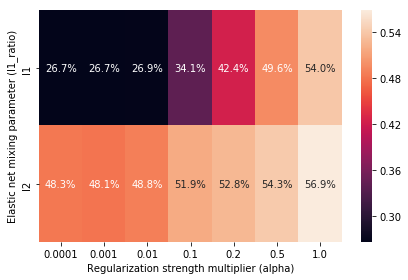

In [23]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__penalty',
                              columns='classify__C')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()